<h6><center>Project Machine Learning</center></h6>

<h1>
<hr style=" border:none; height:3px;">
<center>Part 2 - Data Cleaning : Dimensionality Reduction </center>
<hr style=" border:none; height:3px;">
</h1>



We are going to test out these different approaches for dimensionality reduction :

+ Best/Forward/Backward selection and evaluation methods (adjusted training error, validation set, cross validation)
+ PCA (tunning of $M$ value, visualization and interpretation of the plots

## For google.colab

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setup


In [1]:
!pip install statsmodels

In [2]:
!pip install chart_studio

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# numpy arrays are used to 
import numpy as np

# pandas is used to manipulate tabular data
import pandas as pd

# statsmodels provides classes and functions for the estimation of many different statistical models
import statsmodels.api as sm

# itertools implements a number of iterator building blocks for efficient looping
import itertools

# time provides various time-related functions
import time

# seaborn for correlation
import seaborn as sns

# Matplotlib is used to plot graphs
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Style options for plots
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Saves a figure to a file
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join("./figs", fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## For PCA part
#################
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error

# Some libraries for PCA visualization
import seaborn as sns 
#Make Plotly figure
import chart_studio.plotly as py
# Be aware, plotly may be installed using pip on your shell:
# conda install -c plotly chart-studio
import plotly.graph_objs as go

## Download Data 

We're going to download `data_airbnb` dataset. Our data has already been cleaned, scaled and split into train/validation/test sets. First of all, we are only using the training observations. In a second part, in order to test our data we will use only the validation set. We will also prepare the functions for the test set in order to be able to use it at the end.

Our objective is: 
+ to apply dimensionality reduction approaches 
+ to predict the `Price` of a night's accommodation on Airbnb in Berlin

In [4]:
# Load data train
data_train_df = pd.read_csv("/Users/albane/Desktop/ML/ml-project/data/data_train.csv")
data_train_df.head()
#data_train_df.describe()

# Load data validation
data_validation_df = pd.read_csv("/Users/albane/Desktop/ML/ml-project/data/data_val.csv")

# Load data test
data_test_df = pd.read_csv("/Users/albane/Desktop/ML/ml-project/data/data_test.csv")

Text(0.5, 1.0, 'Correlation between different fearures')

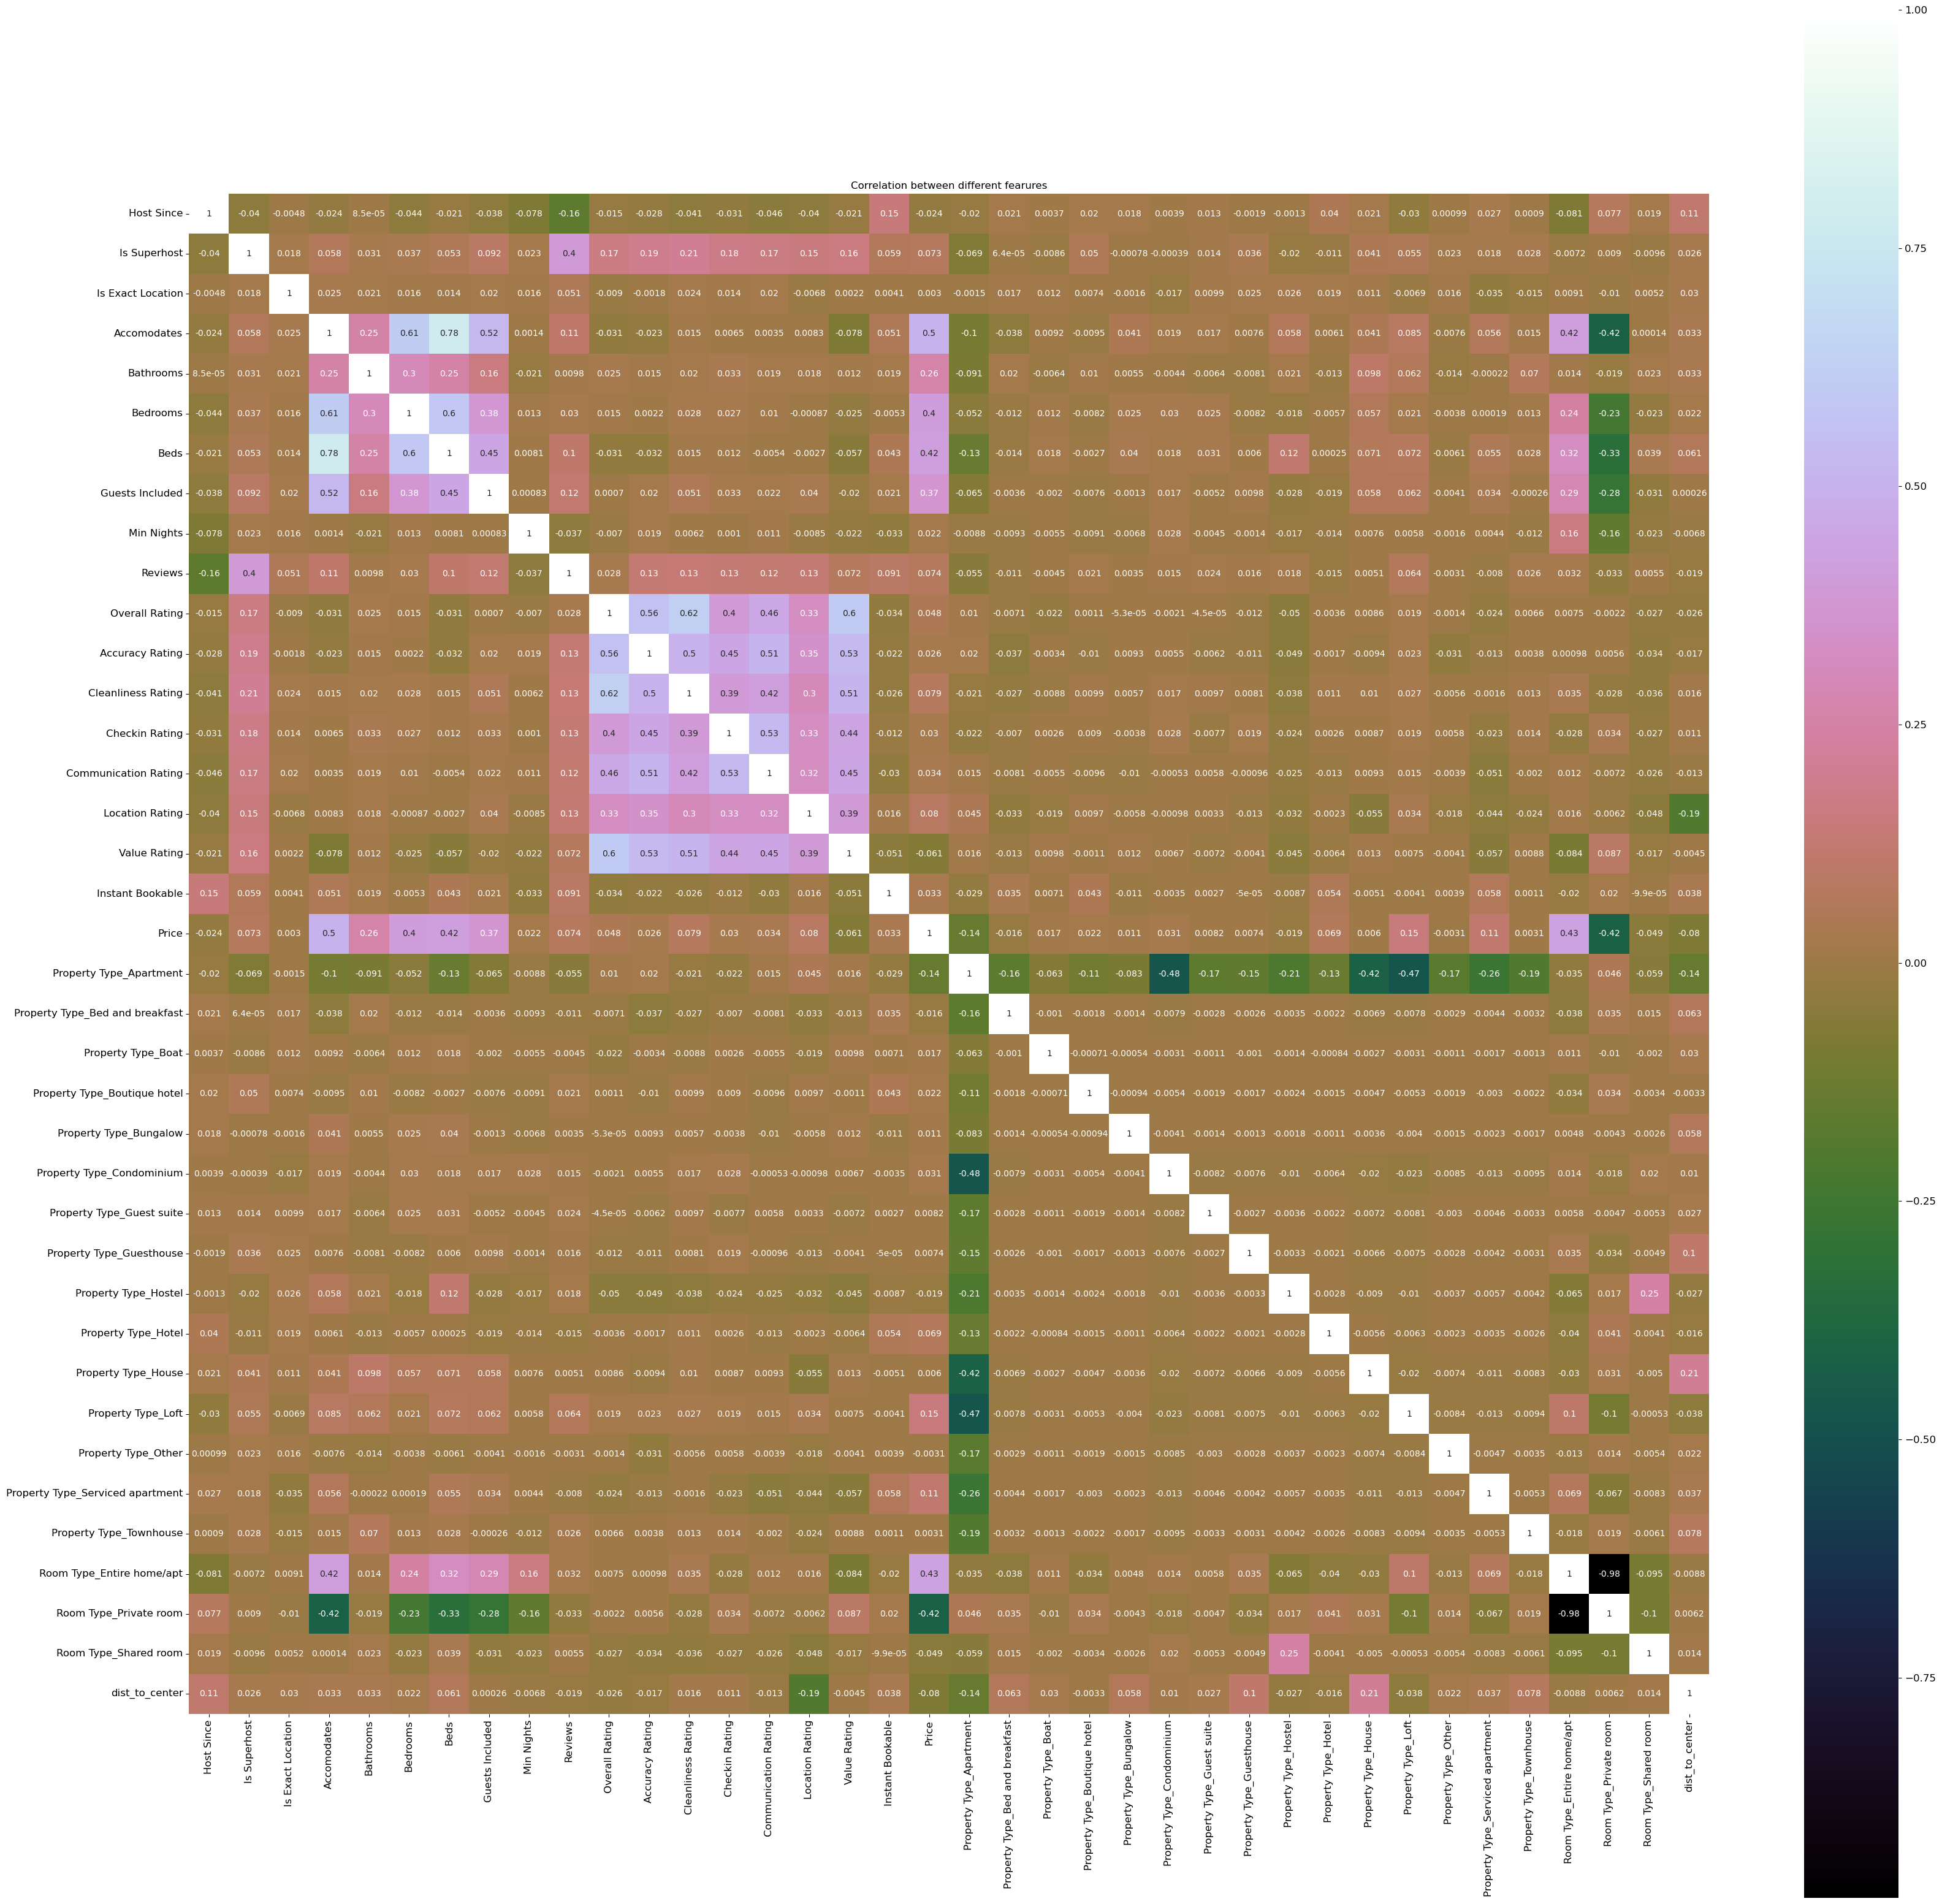

In [5]:
correlation = data_train_df.corr()
plt.figure(figsize=(40,40))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

plt.title('Correlation between different fearures')

# Subset Selection Approaches


## Best Subset Selection

Our dataset has already been cleaned, scaled and split in the first part $Data$ $Cleaning$. We are only using the training observations.

In [6]:
# Extract the target variable
y_train = data_train_df.Price

# Drop the column with the target variable ('Price')
X_train = data_train_df.drop(['Price'], axis=1)

# Define the feature set X_train, our matrix data
X_train.shape

(9772, 37)

Using RSS, we will determine the best model:

In [7]:
def processSubset(feature_set):
    # Fit OLS (Ordinary Least Squares) model on feature_set and calculate RSS
    model = sm.OLS(y_train,X_train[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X_train[list(feature_set)]) - y_train) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [8]:
def getBest(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(X_train.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

The function returns a Dataframe with the best model.

We then call the function for each number of features $k$ (to save time, we only generated results up to the best 3-feature model) : 

In [9]:
models_best = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in range(1,4):
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 37 models on 1 predictors in 0.11923718452453613 seconds.
Processed 666 models on 2 predictors in 1.998811960220337 seconds.
Processed 7770 models on 3 predictors in 24.483197927474976 seconds.
Total elapsed time: 27.541280031204224 seconds.


We get a Dataframe with the best models we have generated and their RSS :

In [10]:
models_best

,RSS,model
1,22.973896,<statsmodels.regression.linear_model.Regressio...
2,19.334853,<statsmodels.regression.linear_model.Regressio...
3,17.759781,<statsmodels.regression.linear_model.Regressio...


With the `summary()` function we can access the details of a single model:

In [11]:
print(models_best.loc[3, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.703
Model:                            OLS   Adj. R-squared (uncentered):              0.703
Method:                 Least Squares   F-statistic:                              7694.
Date:                Wed, 26 Oct 2022   Prob (F-statistic):                        0.00
Time:                        11:04:13   Log-Likelihood:                          16966.
No. Observations:                9772   AIC:                                 -3.393e+04
Df Residuals:                    9769   BIC:                                 -3.391e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

This output indicates that the best 3-feature model contains only `Accomodates`, `Bathrooms` and `Room Type_Entire home/apt`. 

For the best 38-feature model, there is no model. Let's see for the best 37-feature model (there is only one) :

In [12]:
# Show the best 37-feature model 
print(getBest(37)["model"].summary())

Processed 1 models on 37 predictors in 0.06622505187988281 seconds.
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     183.1
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        11:04:16   Log-Likelihood:                 17457.
No. Observations:                9772   AIC:                        -3.484e+04
Df Residuals:                    9736   BIC:                        -3.458e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

$R^2$ value of our best 3-feature model:

In [14]:
models_best.loc[3, "model"].rsquared

0.7026341795420095

The OLS fit also produced many other useful statistics such as **adjusted $R^2$**, **AIC**, and **BIC**. Let us start by looking at the $R^2$ of all our models:

In [15]:
# Gets the second element from each row ('model') and pulls out its rsquared attribute
models_best.apply(lambda row: row[1].rsquared, axis=1)

1    0.615330
2    0.676262
3    0.702634
dtype: float64

$R^2$ statistic increases as more features are included.

Let's look at **RSS**, **adjusted-$R^2$**, **AIC** and **BIC** will allow us to refine our choice:




Text(0, 0.5, 'BIC')

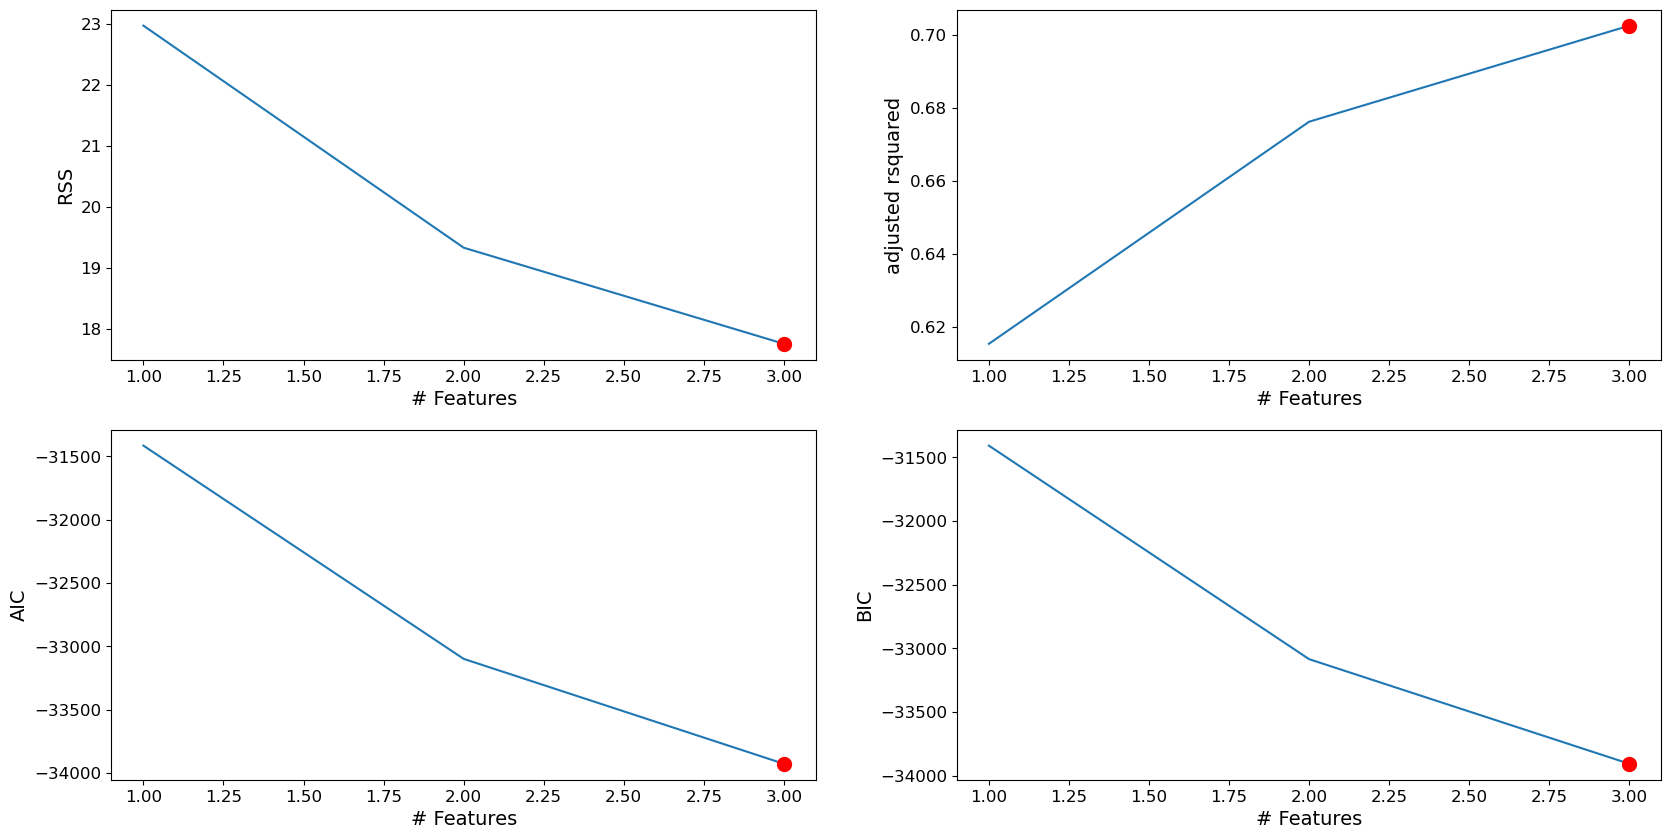

In [25]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the lowest RSS value.
# The argmin() function can be used to identify the location of the minimum point of a vector.
rss = models_best["RSS"]
rss = rss.astype(float)
plt.plot(rss)
plt.plot(rss.argmin()+1, rss.min(), "or")
plt.xlabel('# Features')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector.

rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax()+1, rsquared_adj.max(), "or")
plt.xlabel('# Features')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_best.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin()+1, aic.min(), "or")
plt.xlabel('# Features')
plt.ylabel('AIC')

bic = models_best.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin()+1, bic.min(), "or")
plt.xlabel('# Features')
plt.ylabel('BIC')

Recall that in the second step of our selection process, we narrowed the field down to just one model on any  𝑘<=𝑑  features. We see that according to **adjusted-$R^2$**, **AIC**, and **BIC**, the best performer is the model with 3 features. However, no conclusions can be drawn from the reduction of our model to a maximum of 3 features.

## Forward and Backward Stepwise Selection

We can also set up a forward stepwise or backward stepwise selection:

### Forward Selection

In [26]:
def forward(features):

    # Pull out features we still need to process
    remaining_features = [d for d in X_train.columns if d not in features]
    
    tic = time.time()
    
    results = []
    
    for d in remaining_features:
        results.append(processSubset(features+[d]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the lowest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(features)+1, "features in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

Running time :

In [27]:
models_fwd = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
features = []

for i in range(1,len(X_train.columns)+1):    
    models_fwd.loc[i] = forward(features)
    features = models_fwd.loc[i]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  37 models on 1 features in 0.33517885208129883 seconds.
Processed  36 models on 2 features in 0.09022212028503418 seconds.
Processed  35 models on 3 features in 0.14011788368225098 seconds.
Processed  34 models on 4 features in 0.12213778495788574 seconds.
Processed  33 models on 5 features in 0.10293793678283691 seconds.
Processed  32 models on 6 features in 0.10704779624938965 seconds.
Processed  31 models on 7 features in 0.11548686027526855 seconds.
Processed  30 models on 8 features in 0.1274127960205078 seconds.
Processed  29 models on 9 features in 0.13315916061401367 seconds.
Processed  28 models on 10 features in 0.12877869606018066 seconds.
Processed  27 models on 11 features in 0.15358591079711914 seconds.
Processed  26 models on 12 features in 0.12942194938659668 seconds.
Processed  25 models on 13 features in 0.1351311206817627 seconds.
Processed  24 models on 14 features in 0.14841866493225098 seconds.
Processed  23 models on 15 features in 0.13837409019470215 

This method makes it possible to go much faster.

In [28]:
print(models_fwd.loc[1, "model"].summary())
print(models_fwd.loc[2, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.615
Model:                            OLS   Adj. R-squared (uncentered):              0.615
Method:                 Least Squares   F-statistic:                          1.563e+04
Date:                Wed, 26 Oct 2022   Prob (F-statistic):                        0.00
Time:                        11:11:55   Log-Likelihood:                          15709.
No. Observations:                9772   AIC:                                 -3.142e+04
Df Residuals:                    9771   BIC:                                 -3.141e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

With forward stepwise selection, the best one-feature model contains only the variable `Accomodates`. For the best two-feature model, we have the variables `Accomodates` and `Bathrooms`. 
Let us compare with the method Best Subset Selection for 3-feature model:

In [29]:
print(models_best.loc[3, "model"].summary())
print(models_fwd.loc[3, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.703
Model:                            OLS   Adj. R-squared (uncentered):              0.703
Method:                 Least Squares   F-statistic:                              7694.
Date:                Wed, 26 Oct 2022   Prob (F-statistic):                        0.00
Time:                        11:11:58   Log-Likelihood:                          16966.
No. Observations:                9772   AIC:                                 -3.393e+04
Df Residuals:                    9769   BIC:                                 -3.391e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

The best one-feature through 3-feature models are each identical for best subset and forward selection.

### Backward Selection

In [30]:
def backward(features):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(features, len(features)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(features)-1, "features in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [31]:
models_bwd = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(X_train.columns)))

tic = time.time()
features = X_train.columns

while(len(features) > 1):  
    models_bwd.loc[len(features)-1] = backward(features)
    features = models_bwd.loc[len(features)-1]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  37 models on 36 features in 0.8324940204620361 seconds.
Processed  36 models on 35 features in 0.6099498271942139 seconds.
Processed  35 models on 34 features in 0.4619638919830322 seconds.
Processed  34 models on 33 features in 0.43524909019470215 seconds.
Processed  33 models on 32 features in 0.4513211250305176 seconds.
Processed  32 models on 31 features in 0.4270060062408447 seconds.
Processed  31 models on 30 features in 0.3995048999786377 seconds.
Processed  30 models on 29 features in 0.33937597274780273 seconds.
Processed  29 models on 28 features in 0.30020880699157715 seconds.
Processed  28 models on 27 features in 0.2826530933380127 seconds.
Processed  27 models on 26 features in 0.2746899127960205 seconds.
Processed  26 models on 25 features in 0.24596285820007324 seconds.
Processed  25 models on 24 features in 0.2149219512939453 seconds.
Processed  24 models on 23 features in 0.2034440040588379 seconds.
Processed  23 models on 22 features in 0.1810591220855713 

For this data, the best 1-feature through 3-feature models are each identical for best subset and forward selection. 
We will only compare between backward stepwise selection and forward stepwise selection, when the identified features change (we cannot compare to the best subset model because for time reasons, our model stops at three features):

In [32]:
print("------------")
print("Best Subset:")
print("------------")
print(models_best.loc[3, "model"].params)

------------
Best Subset:
------------
Accomodates                  0.143911
Bathrooms                    0.066513
Room Type_Entire home/apt    0.028124
dtype: float64


In [33]:
print("-----------------")
print("Foward Selection:")
print("-----------------")
print(models_fwd.loc[8, "model"].params)

-----------------
Foward Selection:
-----------------
Accomodates                  0.090284
Bathrooms                    0.092773
Room Type_Entire home/apt    0.029344
dist_to_center              -0.042148
Bedrooms                     0.055319
Property Type_Apartment     -0.012187
Guests Included              0.050681
Property Type_Hotel          0.091766
dtype: float64


In [34]:
print("-------------------")
print("Backward Selection:")
print("-------------------")
print(models_bwd.loc[8, "model"].params)

-------------------
Backward Selection:
-------------------
Accomodates                  0.090284
Bathrooms                    0.092773
Bedrooms                     0.055319
Guests Included              0.050681
Property Type_Apartment     -0.012187
Property Type_Hotel          0.091766
Room Type_Entire home/apt    0.029344
dist_to_center              -0.042148
dtype: float64


The best 1-feature through 8-feature models are each identical for forward subset and backward selection. However, the best 9-feature models identified by forward step selection and backward step selection are different.

## Choosing among models using Validation Set approach and Cross-Validation

We just saw that it is possible to choose among a set of models of different sizes using **AIC**, **BIC**, and **adjusted-$R^2
$**. We will now consider how to do this using the validation set and cross-validation approaches.

We use only the training observations to perform all aspects of model fitting, including variable selection, and thus determine the best model. We have already divided our dataset into a train/validation/test set.

### Declaration variables

In [35]:
train = data_train_df
validation = data_validation_df
test = data_test_df

In [36]:
## For train set
# Extract the target variable
y_train = data_train_df.Price

# Drop the column with the target variable ('Price')
X_train = data_train_df.drop(['Price'], axis=1)

# Define the feature set X_train, our matrix data
X_train.shape

## For validation set
# Extract the target variable
y_validation = data_validation_df.Price

# Drop the column with the target variable ('Price')
X_validation = data_validation_df.drop(['Price'], axis=1)

# Define the feature set X_validation, our matrix data
X_validation.shape

## For test set
# Extract the target variable
y_test = data_test_df.Price

# Drop the column with the target variable ('Price')
X_test = data_test_df.drop(['Price'], axis=1)

# Define the feature set X_test, our matrix data
X_test.shape

## Concatenation for the full dataset
X = pd.concat([X_train,X_validation])
y = pd.concat([y_train,y_validation])

### Model selection using Validation Set approach

We'll define our helper function to outputs the best set of features for each model size like we did in previous part of the lab. Note that we'll need to modify this to take in both validation and training sets, because we want the returned error to be the **validation error** :

In [37]:
def processSubset(feature_set, X_train, y_train, X_validation, y_validation):
    # Fit OLS model on feature_set (from train)
    model = sm.OLS(y_train,X_train[list(feature_set)])
    regr = model.fit()
    # Compute RSS using model predictions on feature_set (from validation set) and the true validation test value of the target
    RSS = ((regr.predict(X_validation[list(feature_set)]) - y_validation) ** 2).sum()
    return {"model":regr, "RSS":RSS}

Our update function to perform forward selection in the context of validation set approach:

In [38]:
def forwardCV(features, X_train, y_train, X_validation, y_validation):
    
    results = []

    # Pull out features we still need to process
    remaining_features = [d for d in X_train.columns if d not in features]
    
    for d in remaining_features:
        results.append(processSubset(features+[d], X_train, y_train, X_validation, y_validation))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
        
    # Return the best model, along with some other useful information about the model
    return best_model

Now, we'll call our `forwardCV()` function on the training set in order to perform forward selection for all model sizes:

In [39]:
models_train = pd.DataFrame(columns=["RSS", "model"])

features = []

for i in range(1,len(X_train.columns)+1):    
    models_train.loc[i] = forwardCV(features, X_train, y_train, X_validation, y_validation)
    features = models_train.loc[i]["model"].model.exog_names

Now let's plot the errors, and find the model that minimizes it:

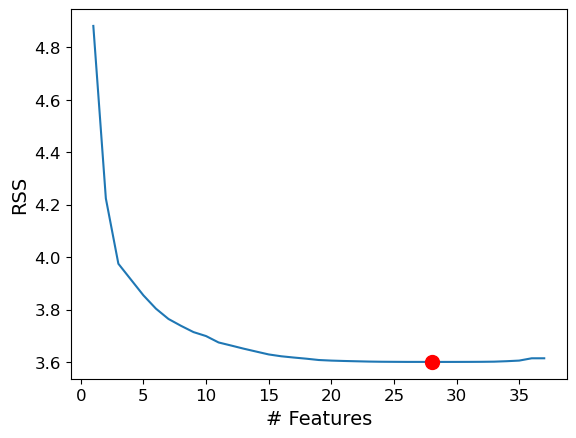

In [47]:
plt.plot(models_train["RSS"])
plt.xlabel('# Features')
plt.ylabel('RSS')
models_train["RSS"] = models_train["RSS"].astype(float)
plt.plot(models_train["RSS"].argmin()+1, models_train["RSS"].min(), "or")
# We use "models_train["RSS"].argmin()+1" because python start counting at zero

#print(models_train["RSS"].argmin())
#print(models_train["RSS"].argmin()+1)
#print(models_train["RSS"].min())
#print(models_train["RSS"])

We find that the best model according to the validation set approach is the one that contains 27 features. However, here, we observe that after 8 features the RSS tends to stagnate.

Then, we can perform best subset selection on the full dataset (here train and validation set) and select the best 8-feature model. It is important that we make use of the full data set in order to obtain more accurate coefficient estimates. We perform this selection on the full data set and select the best 8-feature model, rather than simply using the features that we obtained from the training set, because the best 8-feature model on the full data set may differ from the corresponding model on the training set.

In [48]:
## For validation set
models_validation = pd.DataFrame(columns=["RSS", "model"])

features = []

for i in range(1,9):    
    models_validation.loc[i] = forwardCV(features, X_validation, y_validation, X_validation, y_validation)
    features = models_validation.loc[i]["model"].model.exog_names



## For test set
#models_test = pd.DataFrame(columns=["RSS", "model"])

#features = []

#for i in range(1,9):    
    #models_test.loc[i] = forwardCV(features, X[test], y[test], X[test], y[test])
    #features = models_test.loc[i]["model"].model.exog_names

### Model selection using Cross-Validation approach

Now let's try to choose among the models of different sizes using cross-validation. This approach is somewhat involved, as we must perform forward selection within each of the `K` training sets. First, we create a vector that assigns each observation to one of `K`=10 folds, and we create a `DataFrame` in which we will store the results:

In [49]:
# Number of folds
K = 10
np.random.seed(seed=1)
folds = np.random.choice(K, size = len(y), replace = True)

# Create a DataFrame to store the results of our upcoming calculations
cv_errors = pd.DataFrame(columns=range(1,K+1), index=range(1,39))
cv_errors = cv_errors.fillna(0)

Now let's write a for loop that performs cross-validation. In the  `K`th fold, the elements of folds that equal `K` are in the validation set, and the remainder are in the training set. We make our predictions for each model size, compute the validation errors on the appropriate subset, and store them in the appropriate slot in the matrix `cv_errors`.

In [50]:
models_cv = pd.DataFrame(columns=["RSS", "model"])
    
# Outer loop iterates over all folds
for k in range(1,K+1):

    # Reset features
    features = []
    
    # Inner loop iterates over each size i
    for i in range(1,len(X.columns)+1):    
    
        # The perform forward selection on the full dataset minus the kth fold, validation on kth fold
        models_cv.loc[i] = forwardCV(features, X[folds != (k-1)], y[folds != (k-1)], X[folds == (k-1)], y[folds == (k-1)])
        
        # Save the cross-validated error for this fold
        cv_errors[k][i] = models_cv.loc[i]["RSS"]

        # Extract the features
        features = models_cv.loc[i]["model"].model.exog_names

/var/folders/3z/cz7rjl057wg_42pr21gjw_140000gn/T/ipykernel_37129/1001303376.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv_errors[k][i] = models_cv.loc[i]["RSS"]
/var/folders/3z/cz7rjl057wg_42pr21gjw_140000gn/T/ipykernel_37129/1001303376.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv_errors[k][i] = models_cv.loc[i]["RSS"]
/var/folders/3z/cz7rjl057wg_42pr21gjw_140000gn/T/ipykernel_37129/1001303376.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [51]:
cv_errors

,1,2,3,4,5,6,7,8,9,10
1,2.049933,3.061504,2.753540,3.070948,3.444763,2.944881,2.030837,2.386810,3.213260,2.405666
2,1.586865,2.627736,2.334815,2.730192,2.980466,2.430121,1.590357,2.000737,2.910345,2.055451
3,1.499434,2.520461,2.245593,2.500082,2.864523,2.322321,1.484654,1.873162,2.745739,1.897107
4,1.416158,2.457576,2.154078,2.442324,2.818062,2.244617,1.389244,1.833762,2.681993,1.848518
5,1.394752,2.406376,2.090184,2.401960,2.787583,2.207187,1.328851,1.801524,2.615352,1.807414
6,1.380484,2.367839,2.064299,2.367848,2.768377,2.182991,1.276499,1.756230,2.587213,1.773435
7,1.363896,2.339408,2.039616,2.338499,2.756880,2.173056,1.240779,1.731551,2.560778,1.745050
8,1.344276,2.317145,2.021081,2.308269,2.742478,2.167643,1.226267,1.718733,2.540509,1.730535
9,1.335998,2.305914,2.005834,2.297136,2.730558,2.164335,1.214063,1.707282,2.497563,1.719385
10,1.328345,2.296491,1.985407,2.284081,2.724779,2.163035,1.209678,1.696586,2.488824,1.711736


This has filled up the `cv_errors` Dataframe such that the $(i,k)^{th}$ element corresponds to the test `MSE` for the $k$th cross-validation fold for the best $i$-feature model. We can then use the `apply()` function to take the mean over the columns of this matrix. This will give us a vector for which the $i$th element is the cross-validation error for the $i$-variable model.

1     2.736214
2     2.324708
3     2.195308
4     2.128633
5     2.084118
6     2.052522
7     2.028951
8     2.011694
9     1.997807
10    1.988896
11    1.982100
12    1.976795
13    1.972832
14    1.968935
15    1.966317
16    1.965109
17    1.964268
18    1.963617
19    1.963064
20    1.962827
21    1.962732
22    1.962786
23    1.962941
24    1.963104
25    1.963713
26    1.964824
27    1.964271
28    1.965431
29    1.965951
30    1.965062
31    1.964935
32    1.965956
33    1.967732
34    1.971205
35    1.975303
36    1.988140
37    1.988594
38    0.000000
dtype: float64


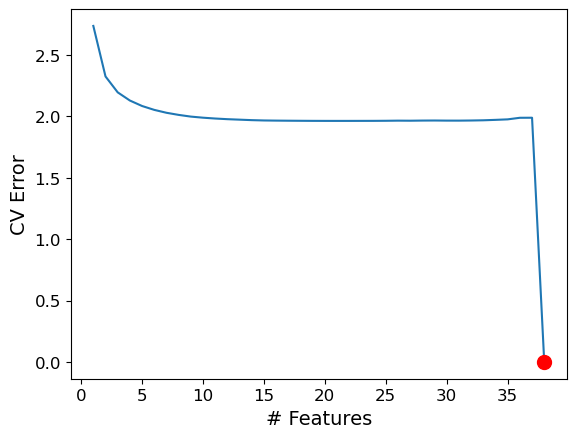

In [52]:
cv_mean = cv_errors.apply(np.mean, axis=1)
print(cv_mean)

plt.plot(cv_mean)
plt.xlabel('# Features')
plt.ylabel('CV Error')
plt.plot(cv_mean.argmin()+1, cv_mean.min(), "or")

We see that cross-validation selects a 38-feature model. However, to continue, we will choose the value of 8 features (after this value the error tends to stagnate). Now let's go back to our results on the full data set in order to obtain the 8-feature model.

In [53]:
print(models_cv.loc[8, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.713
Model:                            OLS   Adj. R-squared (uncentered):              0.712
Method:                 Least Squares   F-statistic:                              3406.
Date:                Wed, 26 Oct 2022   Prob (F-statistic):                        0.00
Time:                        11:16:15   Log-Likelihood:                          19304.
No. Observations:               10993   AIC:                                 -3.859e+04
Df Residuals:                   10985   BIC:                                 -3.853e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

# Dimension Reduction Methods

##  Principal Components Analysis (PCA)

Principal Components Analysis (PCA) is a popular approach for deriving a low-dimensional set of features from a large set of features. This reduction dimension method can be performed using the PCA() function, which is part of the sklearn library. 

### Set up !

In [54]:
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error
import mpl_toolkits.mplot3d 

# Some libraries for PCA visualization
import seaborn as sns 
#Make Plotly figure
import chart_studio.plotly as py
# Be aware, plotly may be installed using pip on your shell:
# conda install -c plotly chart-studio
import plotly.graph_objs as go

### PCA

We'll start by performing Principal Components Analysis (PCA), remembering to scale the data. As our data has already been scaled, we took our unscaled data in order to perform PCA.

In [55]:
## Download train dataset
# Extract the target variable
y_train = data_train_df.Price

# Drop the column with the target variable ('Price')
X_train = data_train_df.drop(['Price'], axis=1)


## Download validation dataset
# Extract the target variable
y_validation = data_validation_df.Price

# Drop the column with the target variable ('Price')
X_validation = data_validation_df.drop(['Price'], axis=1)


## Download test dataset
# Extract the target variable
y_test = data_test_df.Price

# Drop the column with the target variable ('Price')
X_test = data_test_df.drop(['Price'], axis=1)

Now let's perform PCA on the training data and evaluate its validation set performance. This process is also helpful to tune the hyper-parameter $M$ and identify the number of components to use. We'll perform 10-fold cross-validation to see how it influences the `MSE`:

[0.0027259544689724477, 0.0022081421239167646, 0.0021987559864257247, 0.0021993728233650213, 0.0021724220518390576, 0.002144636645664632, 0.0021443007276066373, 0.002136603676745336, 0.0017981160321103081, 0.0017907856522058313, 0.0017520733447084832, 0.001745030941637064, 0.0017306175220244218, 0.0017281074038985455, 0.0017208243485374926, 0.0017214311270189193, 0.0016978430127836599, 0.0016959030356793543, 0.0016968827025249209, 0.0016950261082656376, 0.0016952811977388224, 0.001695894646699072, 0.0016878917771837112, 0.0016882007239616549, 0.0016875450642461806, 0.001685731035999843, 0.0016859886200796409, 0.001685866445298012, 0.0016851605356385485, 0.0016844099878946441, 0.001678233887113669, 0.0016792010593817013, 0.0016666822849144183, 0.0016665837050787724, 0.0016666406438696432, 0.0016668523636986534, 0.0016664548897710788, 0.0016664262624057628, 0.0016664262624057628]


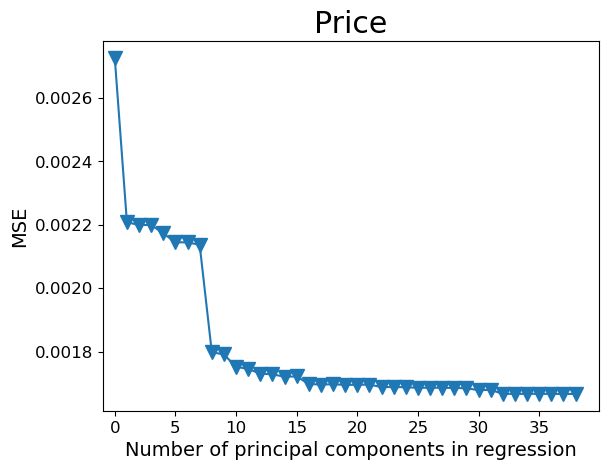

In [56]:
pca = PCA()
X_train_reduced = pca.fit_transform(X_train)

n = len(X_train_reduced)

# 10-fold CV, with shuffle
kf_10 = model_selection.KFold( n_splits=10, shuffle=True, random_state=1)

mse = []

regr = LinearRegression()

# Compute MSE with only the intercept (no principal components in regression)
#and 10-fold CV is only applied on the validation set
score = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)
#print(mse)

# Compute MSE using CV for the 38 principal components, adding one component at the time
#10-fold CV is only applied on the train set
for i in np.arange(1, 39):
    score = -1*model_selection.cross_val_score(regr, X_train_reduced[:,:i], y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Price')
plt.xlim(xmin=-1);

print(mse)

We see that the smallest cross-validation error occurs when $M=35$ components are used. However, from the plot we also see that the cross-validation error is roughly the same when only 8 components are included in the model. This suggests again that a model that uses just a small number of components might suffice. 

We'll print the amount of variance explained by adding each consecutive principal component:

In [57]:
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))
#print(pca.explained_variance_ratio_)
#print(pca.singular_values_)

[ 35.31  51.12  64.65  74.14  81.05  83.78  86.06  88.19  89.77  91.18
  92.2   93.08  93.76  94.34  94.9   95.38  95.84  96.25  96.65  97.04
  97.42  97.76  98.03  98.3   98.54  98.75  98.96  99.15  99.34  99.53
  99.7   99.83  99.92  99.97 100.   100.   100.  ]


Setting $M=1$ only captures 35.3% of all the variance, or information, in the features. In contrast, using $M=8$ increases the value to 88.18%. 

Now, we fix the hyper-parameter  $M$  to 8, and we'll see how it performs on the validation data and compute the validation MSE as follows: 

In [58]:
## For validation set
X_validation_reduced = pca.fit_transform(X_validation)[:,:8]

#print(X_validation_reduced.shape)
#pd.DataFrame(X_validation_reduced).info()

# If you want to compare before and after to apply the PCA:
#print(pd.DataFrame(X_validation_reduced).describe())
#print(pd.DataFrame(X_validation).describe())

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_train_reduced[:,:8], y_train)

# Prediction with validation data
pred = regr.predict(X_validation_reduced)
print('The final test MSE is: ',mean_squared_error(y_validation, pred))



## For test set
#X_test_reduced = pca.fit_transform(X_test)[:,:8]

#regr = LinearRegression()
#regr.fit(X_train_reduced[:,:8], y_train)

#pred = regr.predict(X_test_reduced)
#print('The final test MSE is: ',mean_squared_error(y_test, pred))

The final test MSE is:  0.0016477221436360125


The MSE values are very low because we have normalised our values 

## PCA visualization for $M=8$ components on data_airbnb dataset

This part is intended to more visualize PCA using python. We continue to work on the `data_airbnb` dataset that has 38 features which we can reduce to $M=8$ (as suggested by the previous part of this lab) by using PCA.

In PCA(), `n_component` specifies how many components are returned after fit and tranformation.

In [59]:
## For validation set
pcamodel = PCA(n_components=8)
pca = pcamodel.fit_transform(X_validation)
pca.shape

## For test set
#pcamodel = PCA(n_components=8)
#pca = pcamodel.fit_transform(X_test)
#pca.shape

(2443, 8)

PCA components and their significance can be explained using `explained_variance_ratio_` that is the percentage of variance explained by each of the selected components.

In [60]:
#the percentage of variance explained by each of the selected components
pcamodel.explained_variance_ratio_

array([0.3542256 , 0.1559272 , 0.1368805 , 0.09639293, 0.06518647,
       0.02863538, 0.0251725 , 0.0211633 ])

Some PCA model attribute plots can help for visualization:

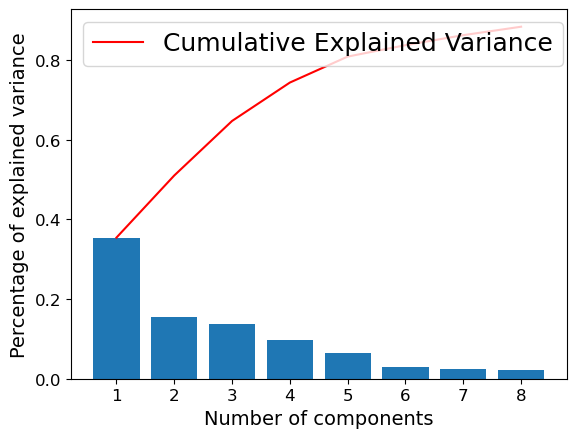

In [61]:
# Explained variance plot
plt.bar(range(1,len(pcamodel.explained_variance_ratio_ )+1),pcamodel.explained_variance_ratio_ )
plt.ylabel('Percentage of explained variance')
plt.xlabel('Number of components')
plt.plot(range(1,len(pcamodel.explained_variance_ratio_ )+1),
         np.cumsum(pcamodel.explained_variance_ratio_ ),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper left')


Scree plot is the plot of eigen values (explained_variance_) for each of the components.

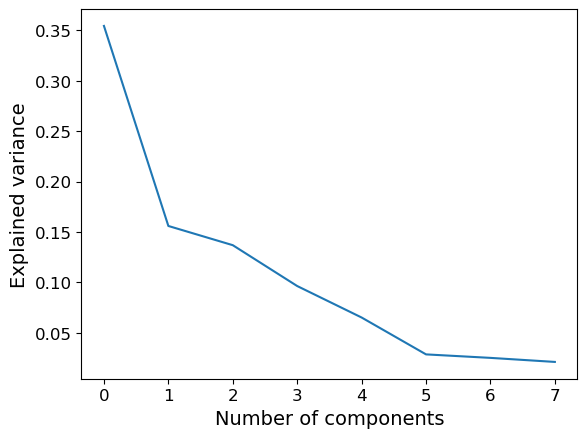

In [62]:
# Scree plot
plt.plot(pcamodel.explained_variance_ratio_)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.show()

It can be seen from plots that, eight first components explains most of the variance than subsequent components. Here, most of the features are explained and encompassed by the eight first components. 

# Conclusion and dimensionality reduction to 8 features

We observe, from forward and backward selection and also by PCA that the group of 8 features : `Accomodates`, `Bathrooms`, `Bedrooms`, `Guests Included`, `Property Type_Apartment`, `Property Type_Hotel`, `Room Type_Entire home/apt` and `dist-to-center`, explains most of the variance. We will now reduce our full dataset to those 8 features.

Let's run the cleaned and scaled files obtained in data_cleaning.py (data_train_df, data_validation_df and data_test_df) to obtain reduced CSVs of these files:

In [64]:
import pandas as pd
import numpy as np
import os

class ReductionDim:
    columns_to_keep = [
          'Accomodates',
          'Bathrooms',
          'Bedrooms',
          'Guests Included',
          'Property Type_Apartment',
          'Property Type_Hotel',
          'Room Type_Entire home/apt',
          'dist_to_center',
    ]

    def __init__(self, path: str) -> None:
            self.path = path
            self.df = None

    def df_creation(self):
            """ Loading the DataFrame."""
            self.df = pd.read_csv(self.path)
            # Dropping columns
            self.df = self.df[ReductionDim.columns_to_keep + ['Price']]

    def save_csv(self, df: pd.DataFrame, csv_name:str):
        """ Saves the cleaned dataframe in a csv file in the same folder as the
            one containing the cleaned dataframe.
            Attribute:
                - csv_name : name of the csv file created """
        df.to_csv(os.path.join(self.path.rsplit("/", 1)[0], csv_name), index=False)

    def data_reducdim(self) -> pd.DataFrame:
        """ Main method: applies all the preprocesses. """
        self.df_creation()
        self.save_csv(self.df, csv_name="data_train_reduced.csv")
        self.save_csv(self.df, csv_name="data_val_reduced.csv")
        self.save_csv(self.df, csv_name="data_test_reduced.csv")

data_train_path = "/Users/albane/Desktop/ML/ml-project/data/data_train.csv"
data_val_path = "/Users/albane/Desktop/ML/ml-project/data/data_val.csv"
data_test_path = "/Users/albane/Desktop/ML/ml-project/data/data_test.csv"

data_reducer = ReductionDim(path=data_train_path)
data_reducer.data_reducdim()
data_reducer = ReductionDim(path=data_val_path)
data_reducer.data_reducdim()
data_reducer = ReductionDim(path=data_test_path)
data_reducer.data_reducdim()